# Self-supervised DAS denoising 

In [1]:
import gc
import glob
import h5py
import torch
import scipy
import numpy as np
import torch.nn as nn
from das_util import try_gpu
from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.signal import filtfilt, butter
from scipy.signal.windows import tukey
from torch.utils.data import DataLoader
from das_denoise_models import unet, dataflow1280, datalabel
from das_denoise_training import train_augmentation_fly
from sklearn.model_selection import train_test_split
import matplotlib
plt.rcParams.update({'font.size':24})

In [ ]:
def light_tukey(win_len, alpha=0.5, taper_level=0.5):
    org_func = scipy.signal.windows.tukey(win_len, alpha)
    new_func = (1 - taper_level) * org_func + taper_level
    
    return new_func

In [ ]:
### Secret cell for read while training



class CustomH5Dataset(Dataset):
    def __init__(self, h5_directory, Nx_sub=1280, Nt=1280, max_ch=5000, mask_ratio=0.5):
        """
        Args:
            h5_directory (string): Path to the folder containing all the h5 files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.h5_filepaths = glob.glob(os.path.join(h5_directory, '*.h5'))
        self.transform = transform

    def __len__(self):
        return len(self.h5_filepaths)

    def __getitem__(self, idx):
    
        # Get the path to the .h5 file
        h5_filepath = self.h5_filepaths[idx]
            
        mask = np.ones((Nx_sub, Nt), dtype=np.float32)
            
        with h5py.File(h5_filepath, 'r') as f:
            time_data = f['Acquisition']['Raw[0]']['RawData'][:Nt, 100:(100+max_ch)]
        assert time_data.shape[1] == max_ch, "Not enough #ch to read, adjust max_ch!"
        assert Nx_sub <= max_ch, "max_ch is smaller than the #ch needed for the sample, adjust Nx_sub!"
        
        # %% slice a random portion
        st_ch = np.random.randint(low=0, high=max_ch - Nx_sub)
        sample = time_data.T[st_ch:st_ch+Nx_sub, :Nt]

        rng = np.random.default_rng()
        trace_masked = rng.choice(Nx_sub, size=int(mask_ratio * Nx_sub), replace=False)
        mask[trace_masked, :] = mask[trace_masked, :] * 0
        
        return (samples, mask), sample * (1 - mask)


### Option 1: read raw data

In [2]:
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_11_14.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_14.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['raw_quake'][:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['raw_quake'][:]
print(quake1.shape)
print(quake2.shape)
    
sample_rate = 25
dchan = 10
    
# tmp = np.append(quake2[:,:4500,:], quake1[:,:4500,:], axis=0)
tmp = np.append(quake2[:,:,:], quake1[:,:,:], axis=0)

del quake2, quake1
gc.collect()

b, a = butter(4, (0.5, 12), fs=sample_rate, btype='bandpass')
filt = filtfilt(b, a, tmp, axis=2)
rawdata = filt / np.std(filt, axis=(1,2), keepdims=True)

(182, 7500, 1500)
(182, 7500, 1500)


### Option 2: read the raw and FK-filtered data

Note: 
1. the files *11_14 are for relatively stronger earthquakes (a=-0.95, b=0.65)
2. Other files are using a=-1, b=0.65

In [ ]:
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_11_14.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_14.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['raw_quake'][:]
    label1 = f['fk_quake'][:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['raw_quake'][:]
    label2 = f['fk_quake'][:]

In [ ]:
taper_func = light_tukey(1500, alpha=0.1, taper_level=0.5)
plt.plot(taper_func)
plt.xlim(0,1500)
plt.ylim(0,1.1)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 60, 10).astype(int))
plt.xlabel('time (s)')

In [ ]:
sample_rate = 25
dchan = 10
    
tmp_q = np.append(quake2[:,:4500,:], quake1[:,:4500,:], axis=0)
tmp_l = np.append(label2[:,:4500,:], label1[:,:4500,:], axis=0)

# tmp_q = np.append(quake2[:,:,:], quake1[:,:,:], axis=0)
# tmp_l = np.append(label2[:,:,:], label1[:,:,:], axis=0)

del quake1, quake2, label1, label2
gc.collect()

b, a = butter(4, (0.5, 12), fs=sample_rate, btype='bandpass')
filt_q = filtfilt(b, a, tmp_q, axis=2)
filt_l = filtfilt(b, a, tmp_l, axis=2)
rawdata = filt_q / np.std(filt_q, axis=(1,2), keepdims=True)
fkdata = filt_l / np.std(filt_l, axis=(1,2), keepdims=True) # * taper_func

del tmp_q, tmp_l, filt_q, filt_l
gc.collect()

In [ ]:
# %% visualize data
time_data = rawdata[2]
plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu'); max_amp = np.median(np.fabs(time_data))*2
x, y=np.arange(time_data.shape[1]), np.arange(time_data.shape[0])
plt.pcolormesh(x, y, time_data, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
plt.yticks(np.arange(0, len(y)//1000*1000, 1000), (np.arange(0, len(y)//1000*1000*dchan, 1000*dchan)/1000).astype(int))
plt.xlabel("Time (s)", fontsize=20); plt.ylabel("Distance (km)", fontsize=20)
cbr=plt.colorbar(); cbr.set_label('amplitude', fontsize = 20)

In [ ]:
# %% visualize data and label
i=14
data_in = rawdata[i, :1500,:]
data_lb = fkdata[i, :1500,:]
fig, ax = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
cmap=plt.cm.get_cmap('RdBu'); max_amp = np.median(np.fabs(data_in))*2
x, y=np.arange(data_in.shape[1]), np.arange(data_in.shape[0])
ax[0].pcolormesh(x, y, data_in, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
ax[1].pcolormesh(x, y, data_lb, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
# ax[2].pcolormesh(x, y, data_lb/taper_func*light_tukey(1500, alpha=0.1, taper_level=0.3), shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
for i in range(2):
    ax[i].set_xticks(np.arange(0, 1500, 250)) 
    ax[i].set_xticklabels(np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
    ax[i].set_yticks(np.arange(0, len(y)//200*200, 200))
    ax[i].set_yticklabels((np.arange(0, len(y)//200*200*dchan, 200*dchan)/1000).astype(int))
    ax[i].set_xlabel("Time (s)", fontsize=24)
    ax[i].set_ylabel("Distance (km)", fontsize=24)

### Option 1: input=target

In [3]:
# %% Shuffle and split dataset
X_tr, X, Y_tr, Y = train_test_split(rawdata, rawdata,
                                        train_size=0.7,
                                        random_state=111)
X_va, X_te, Y_va, Y_te = train_test_split(X, Y,
                                        train_size=0.5,
                                        random_state=121)

training_data = dataflow1280(X_tr, stride=320)
validation_data = dataflow1280(X_va, stride=320)
# test_data = dataflow1280(X_te, mask_ratio=0.5)

del tmp, filt, rawdata, X, Y
gc.collect()

0

In [ ]:
len(validation_data)

### Option 2: input !=target

In [ ]:
# %% Shuffle and split dataset
X_tr, X, Y_tr, Y = train_test_split(rawdata, fkdata,
                                        train_size=0.7,
                                        random_state=111)

del rawdata, fkdata
gc.collect()

X_va, X_te, Y_va, Y_te = train_test_split(X, Y,
                                        train_size=0.5,
                                        random_state=121)

training_data = datalabel(X_tr, Y_tr, mask_ratio=0.5, stride=750, n_masks=5)
validation_data = datalabel(X_va, Y_va, mask_ratio=0.5, stride=750, n_masks=5)
# test_data = datalabel(X_te, Y_te, mask_ratio=0.5)

del X, Y, X_tr, Y_tr, X_va, Y_va, X_te, Y_te
gc.collect()

### Construct the neural network

In [ ]:
""" Initialize the U-net model """
model = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
devc = try_gpu(i=0)
model = nn.DataParallel(model, device_ids=[0,1,2,3])  # comment if gpus<4 
model.to(devc)

In [4]:
from models_mae_swinv2 import MaskedAutoencoderSwinV2

model = MaskedAutoencoderSwinV2(img_size=1280,
                                patch_size=10,
                                in_chans=1,
                                out_chans=1,
                                max_dim=768,
                                embed_dim=48,
                                depths=[2, 2, 6, 2],
                                num_heads=[3, 6, 12, 24],
                                window_size=8,
                                mlp_ratio=4,
                                qkv_bias=True,
                                drop_rate=0,
                                drop_path_rate=0.2,
                                patch_norm=True,
                                use_checkpoint=False,
                                pretrained_window_sizes=[0, 0, 0, 0],
                                skip_connection=False,
                                map_to_RGB=False,
                                frozen_stages=[])

devc = try_gpu(i=0)
model = nn.DataParallel(model, device_ids=[0,1,2,3])  # comment if gpus<4 
model.to(devc)

/home/jupyter_share/anaconda3/envs/seismo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jupyter_share/anaconda3/envs/seismo/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


DataParallel(
  (module): MaskedAutoencoderSwinV2(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 48, kernel_size=(10, 10), stride=(10, 10))
      (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=48, input_resolution=(128, 128), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=48, input_resolution=(128, 128), num_heads=3, window_size=(8, 8), shift_size=(0, 0), mlp_ratio=4
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=48, window_size=(8, 8), pretrained_window_size=(0, 0), num_heads=3
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU()
                (2): Linear(in_features=512, out_features=3, bias=False)
              )
              (qkv): Linear(in

### Training

In [6]:
# %% Hyper-parameters for training
batch_size = 128
lr = 1e-4
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.8, 
                                                         patience=5, 
                                                         threshold=0.001, 
                                                         threshold_mode='rel', 
                                                         cooldown=0, 
                                                         min_lr=1e-6, 
                                                         eps=1e-08, 
                                                         verbose=True)

train_iter = DataLoader(training_data, batch_size=batch_size, shuffle=False)
validate_iter = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

In [7]:
avg_train_losses, \
avg_valid_losses = train_augmentation_fly(train_iter,
                                   validate_iter,
                                   model,
                                   loss_fn,
                                   optimizer,
                                   lr_schedule=lr_schedule,
                                   epochs=1000,
                                   patience=30,
                                   device=devc,
                                   Nx_sub=1280,
                                   Nt=1280,
                                   mask_ratio=0.0, 
                                   minimum_epochs=50)

[   1/1000] train_loss: 0.60424 valid_loss: 0.57310 time per epoch: 83.251 s
[   2/1000] train_loss: 0.58093 valid_loss: 0.55154 time per epoch: 79.418 s
[   3/1000] train_loss: 0.56257 valid_loss: 0.53178 time per epoch: 79.221 s
[   4/1000] train_loss: 0.54437 valid_loss: 0.51689 time per epoch: 79.334 s
[   5/1000] train_loss: 0.53226 valid_loss: 0.50589 time per epoch: 79.411 s
[   6/1000] train_loss: 0.52312 valid_loss: 0.49807 time per epoch: 79.237 s
[   7/1000] train_loss: 0.51573 valid_loss: 0.49083 time per epoch: 79.139 s
[   8/1000] train_loss: 0.50878 valid_loss: 0.48384 time per epoch: 79.206 s
[   9/1000] train_loss: 0.50240 valid_loss: 0.47797 time per epoch: 80.258 s
[  10/1000] train_loss: 0.49568 valid_loss: 0.47090 time per epoch: 79.879 s
[  11/1000] train_loss: 0.48911 valid_loss: 0.46442 time per epoch: 79.488 s
[  12/1000] train_loss: 0.48274 valid_loss: 0.45847 time per epoch: 80.237 s
[  13/1000] train_loss: 0.47709 valid_loss: 0.45328 time per epoch: 79.578 s

[  82/1000] train_loss: 0.35484 valid_loss: 0.34534 time per epoch: 79.240 s
Validation loss decreased (0.347132 --> 0.345342).  Saving model ...
[  83/1000] train_loss: 0.35307 valid_loss: 0.34403 time per epoch: 79.295 s
Validation loss decreased (0.345342 --> 0.344031).  Saving model ...
[  84/1000] train_loss: 0.35179 valid_loss: 0.34280 time per epoch: 79.505 s
Validation loss decreased (0.344031 --> 0.342796).  Saving model ...
[  85/1000] train_loss: 0.35078 valid_loss: 0.34207 time per epoch: 79.531 s
Validation loss decreased (0.342796 --> 0.342068).  Saving model ...
[  86/1000] train_loss: 0.34963 valid_loss: 0.34104 time per epoch: 79.550 s
Validation loss decreased (0.342068 --> 0.341042).  Saving model ...
[  87/1000] train_loss: 0.34841 valid_loss: 0.34032 time per epoch: 79.329 s
Validation loss decreased (0.341042 --> 0.340319).  Saving model ...
[  88/1000] train_loss: 0.34734 valid_loss: 0.33929 time per epoch: 79.569 s
Validation loss decreased (0.340319 --> 0.33929

[ 140/1000] train_loss: 0.30048 valid_loss: 0.29944 time per epoch: 79.489 s
Validation loss decreased (0.299660 --> 0.299443).  Saving model ...
[ 141/1000] train_loss: 0.29978 valid_loss: 0.29953 time per epoch: 79.390 s
EarlyStopping counter: 1 out of 30
[ 142/1000] train_loss: 0.29928 valid_loss: 0.29829 time per epoch: 79.129 s
Validation loss decreased (0.299443 --> 0.298291).  Saving model ...
[ 143/1000] train_loss: 0.29829 valid_loss: 0.29790 time per epoch: 79.179 s
Validation loss decreased (0.298291 --> 0.297896).  Saving model ...
[ 144/1000] train_loss: 0.29815 valid_loss: 0.29812 time per epoch: 79.228 s
EarlyStopping counter: 1 out of 30
[ 145/1000] train_loss: 0.29786 valid_loss: 0.29739 time per epoch: 79.415 s
Validation loss decreased (0.297896 --> 0.297391).  Saving model ...
[ 146/1000] train_loss: 0.29727 valid_loss: 0.29731 time per epoch: 79.102 s
Validation loss decreased (0.297391 --> 0.297314).  Saving model ...
[ 147/1000] train_loss: 0.29663 valid_loss: 0.

[ 202/1000] train_loss: 0.27961 valid_loss: 0.28578 time per epoch: 79.335 s
EarlyStopping counter: 1 out of 30
[ 203/1000] train_loss: 0.27978 valid_loss: 0.28592 time per epoch: 79.268 s
EarlyStopping counter: 2 out of 30
[ 204/1000] train_loss: 0.28032 valid_loss: 0.28670 time per epoch: 79.062 s
EarlyStopping counter: 3 out of 30
[ 205/1000] train_loss: 0.27963 valid_loss: 0.28568 time per epoch: 78.942 s
EarlyStopping counter: 4 out of 30
[ 206/1000] train_loss: 0.27934 valid_loss: 0.28711 time per epoch: 78.992 s
EarlyStopping counter: 5 out of 30
Epoch 00207: reducing learning rate of group 0 to 6.4000e-05.
[ 207/1000] train_loss: 0.27927 valid_loss: 0.28536 time per epoch: 79.094 s
EarlyStopping counter: 6 out of 30
[ 208/1000] train_loss: 0.27845 valid_loss: 0.28458 time per epoch: 79.238 s
Validation loss decreased (0.285299 --> 0.284582).  Saving model ...
[ 209/1000] train_loss: 0.27770 valid_loss: 0.28428 time per epoch: 79.099 s
Validation loss decreased (0.284582 --> 0.2

[ 262/1000] train_loss: 0.27067 valid_loss: 0.27988 time per epoch: 79.223 s
EarlyStopping counter: 1 out of 30
Epoch 00263: reducing learning rate of group 0 to 2.0972e-05.
[ 263/1000] train_loss: 0.27031 valid_loss: 0.27976 time per epoch: 79.238 s
Validation loss decreased (0.279822 --> 0.279762).  Saving model ...
[ 264/1000] train_loss: 0.27019 valid_loss: 0.27974 time per epoch: 79.173 s
Validation loss decreased (0.279762 --> 0.279743).  Saving model ...
[ 265/1000] train_loss: 0.27024 valid_loss: 0.27968 time per epoch: 79.147 s
Validation loss decreased (0.279743 --> 0.279676).  Saving model ...
[ 266/1000] train_loss: 0.27010 valid_loss: 0.27964 time per epoch: 79.269 s
Validation loss decreased (0.279676 --> 0.279638).  Saving model ...
[ 267/1000] train_loss: 0.26994 valid_loss: 0.27964 time per epoch: 79.110 s
Validation loss decreased (0.279638 --> 0.279636).  Saving model ...
[ 268/1000] train_loss: 0.26998 valid_loss: 0.27953 time per epoch: 79.822 s
Validation loss dec

Epoch 00319: reducing learning rate of group 0 to 3.5184e-06.
[ 319/1000] train_loss: 0.26799 valid_loss: 0.27836 time per epoch: 79.113 s
Validation loss decreased (0.278385 --> 0.278358).  Saving model ...
[ 320/1000] train_loss: 0.26789 valid_loss: 0.27834 time per epoch: 79.064 s
Validation loss decreased (0.278358 --> 0.278337).  Saving model ...
[ 321/1000] train_loss: 0.26757 valid_loss: 0.27831 time per epoch: 79.225 s
Validation loss decreased (0.278337 --> 0.278312).  Saving model ...
[ 322/1000] train_loss: 0.26793 valid_loss: 0.27837 time per epoch: 78.890 s
EarlyStopping counter: 1 out of 30
[ 323/1000] train_loss: 0.26787 valid_loss: 0.27830 time per epoch: 78.578 s
Validation loss decreased (0.278312 --> 0.278303).  Saving model ...
[ 324/1000] train_loss: 0.26780 valid_loss: 0.27832 time per epoch: 79.102 s
EarlyStopping counter: 1 out of 30
Epoch 00325: reducing learning rate of group 0 to 2.8147e-06.
[ 325/1000] train_loss: 0.26803 valid_loss: 0.27830 time per epoch: 

[ 378/1000] train_loss: 0.26728 valid_loss: 0.27797 time per epoch: 78.463 s
EarlyStopping counter: 2 out of 30
[ 379/1000] train_loss: 0.26722 valid_loss: 0.27796 time per epoch: 78.482 s
Validation loss decreased (0.277972 --> 0.277963).  Saving model ...
[ 380/1000] train_loss: 0.26754 valid_loss: 0.27795 time per epoch: 78.834 s
Validation loss decreased (0.277963 --> 0.277949).  Saving model ...
[ 381/1000] train_loss: 0.26713 valid_loss: 0.27795 time per epoch: 78.771 s
EarlyStopping counter: 1 out of 30
[ 382/1000] train_loss: 0.26726 valid_loss: 0.27795 time per epoch: 78.875 s
EarlyStopping counter: 2 out of 30
[ 383/1000] train_loss: 0.26716 valid_loss: 0.27796 time per epoch: 78.884 s
EarlyStopping counter: 3 out of 30
[ 384/1000] train_loss: 0.26738 valid_loss: 0.27795 time per epoch: 78.900 s
Validation loss decreased (0.277949 --> 0.277949).  Saving model ...
[ 385/1000] train_loss: 0.26731 valid_loss: 0.27794 time per epoch: 78.478 s
Validation loss decreased (0.277949 -

[ 443/1000] train_loss: 0.26699 valid_loss: 0.27772 time per epoch: 79.107 s
Validation loss decreased (0.277727 --> 0.277717).  Saving model ...
[ 444/1000] train_loss: 0.26706 valid_loss: 0.27771 time per epoch: 79.126 s
Validation loss decreased (0.277717 --> 0.277707).  Saving model ...
[ 445/1000] train_loss: 0.26683 valid_loss: 0.27770 time per epoch: 78.861 s
Validation loss decreased (0.277707 --> 0.277703).  Saving model ...
[ 446/1000] train_loss: 0.26712 valid_loss: 0.27771 time per epoch: 78.772 s
EarlyStopping counter: 1 out of 30
[ 447/1000] train_loss: 0.26706 valid_loss: 0.27770 time per epoch: 79.029 s
Validation loss decreased (0.277703 --> 0.277698).  Saving model ...
[ 448/1000] train_loss: 0.26711 valid_loss: 0.27770 time per epoch: 79.044 s
EarlyStopping counter: 1 out of 30
[ 449/1000] train_loss: 0.26703 valid_loss: 0.27770 time per epoch: 79.104 s
Validation loss decreased (0.277698 --> 0.277696).  Saving model ...
[ 450/1000] train_loss: 0.26672 valid_loss: 0.

[ 507/1000] train_loss: 0.26659 valid_loss: 0.27746 time per epoch: 78.951 s
EarlyStopping counter: 1 out of 30
[ 508/1000] train_loss: 0.26685 valid_loss: 0.27747 time per epoch: 78.996 s
EarlyStopping counter: 2 out of 30
[ 509/1000] train_loss: 0.26648 valid_loss: 0.27745 time per epoch: 79.176 s
Validation loss decreased (0.277454 --> 0.277445).  Saving model ...
[ 510/1000] train_loss: 0.26664 valid_loss: 0.27745 time per epoch: 79.108 s
EarlyStopping counter: 1 out of 30
[ 511/1000] train_loss: 0.26655 valid_loss: 0.27743 time per epoch: 79.327 s
Validation loss decreased (0.277445 --> 0.277433).  Saving model ...
[ 512/1000] train_loss: 0.26658 valid_loss: 0.27742 time per epoch: 79.433 s
Validation loss decreased (0.277433 --> 0.277424).  Saving model ...
[ 513/1000] train_loss: 0.26656 valid_loss: 0.27744 time per epoch: 79.306 s
EarlyStopping counter: 1 out of 30
[ 514/1000] train_loss: 0.26671 valid_loss: 0.27743 time per epoch: 79.260 s
EarlyStopping counter: 2 out of 30
[ 

[ 573/1000] train_loss: 0.26614 valid_loss: 0.27718 time per epoch: 79.216 s
Validation loss decreased (0.277185 --> 0.277184).  Saving model ...
[ 574/1000] train_loss: 0.26644 valid_loss: 0.27719 time per epoch: 79.364 s
EarlyStopping counter: 1 out of 30
[ 575/1000] train_loss: 0.26630 valid_loss: 0.27718 time per epoch: 79.336 s
Validation loss decreased (0.277184 --> 0.277178).  Saving model ...
[ 576/1000] train_loss: 0.26615 valid_loss: 0.27717 time per epoch: 79.252 s
Validation loss decreased (0.277178 --> 0.277166).  Saving model ...
[ 577/1000] train_loss: 0.26612 valid_loss: 0.27716 time per epoch: 79.276 s
Validation loss decreased (0.277166 --> 0.277155).  Saving model ...
[ 578/1000] train_loss: 0.26610 valid_loss: 0.27716 time per epoch: 78.838 s
EarlyStopping counter: 1 out of 30
[ 579/1000] train_loss: 0.26610 valid_loss: 0.27716 time per epoch: 78.813 s
EarlyStopping counter: 2 out of 30
[ 580/1000] train_loss: 0.26628 valid_loss: 0.27715 time per epoch: 78.869 s
Val

[ 637/1000] train_loss: 0.26593 valid_loss: 0.27692 time per epoch: 79.290 s
EarlyStopping counter: 3 out of 30
[ 638/1000] train_loss: 0.26585 valid_loss: 0.27692 time per epoch: 79.262 s
EarlyStopping counter: 4 out of 30
[ 639/1000] train_loss: 0.26583 valid_loss: 0.27690 time per epoch: 79.179 s
Validation loss decreased (0.276911 --> 0.276898).  Saving model ...
[ 640/1000] train_loss: 0.26579 valid_loss: 0.27690 time per epoch: 79.302 s
EarlyStopping counter: 1 out of 30
[ 641/1000] train_loss: 0.26602 valid_loss: 0.27690 time per epoch: 78.981 s
EarlyStopping counter: 2 out of 30
[ 642/1000] train_loss: 0.26590 valid_loss: 0.27690 time per epoch: 79.221 s
EarlyStopping counter: 3 out of 30
[ 643/1000] train_loss: 0.26584 valid_loss: 0.27687 time per epoch: 79.553 s
Validation loss decreased (0.276898 --> 0.276866).  Saving model ...
[ 644/1000] train_loss: 0.26568 valid_loss: 0.27687 time per epoch: 79.246 s
EarlyStopping counter: 1 out of 30
[ 645/1000] train_loss: 0.26553 vali

[ 701/1000] train_loss: 0.26549 valid_loss: 0.27666 time per epoch: 79.331 s
EarlyStopping counter: 2 out of 30
[ 702/1000] train_loss: 0.26525 valid_loss: 0.27664 time per epoch: 79.023 s
Validation loss decreased (0.276647 --> 0.276636).  Saving model ...
[ 703/1000] train_loss: 0.26529 valid_loss: 0.27664 time per epoch: 79.302 s
EarlyStopping counter: 1 out of 30
[ 704/1000] train_loss: 0.26555 valid_loss: 0.27663 time per epoch: 79.270 s
Validation loss decreased (0.276636 --> 0.276632).  Saving model ...
[ 705/1000] train_loss: 0.26569 valid_loss: 0.27664 time per epoch: 79.338 s
EarlyStopping counter: 1 out of 30
[ 706/1000] train_loss: 0.26530 valid_loss: 0.27662 time per epoch: 79.306 s
Validation loss decreased (0.276632 --> 0.276616).  Saving model ...
[ 707/1000] train_loss: 0.26541 valid_loss: 0.27662 time per epoch: 79.063 s
EarlyStopping counter: 1 out of 30
[ 708/1000] train_loss: 0.26532 valid_loss: 0.27661 time per epoch: 79.037 s
Validation loss decreased (0.276616 -

[ 765/1000] train_loss: 0.26505 valid_loss: 0.27637 time per epoch: 78.918 s
EarlyStopping counter: 1 out of 30
[ 766/1000] train_loss: 0.26491 valid_loss: 0.27636 time per epoch: 79.045 s
Validation loss decreased (0.276362 --> 0.276358).  Saving model ...
[ 767/1000] train_loss: 0.26508 valid_loss: 0.27635 time per epoch: 78.994 s
Validation loss decreased (0.276358 --> 0.276353).  Saving model ...
[ 768/1000] train_loss: 0.26517 valid_loss: 0.27636 time per epoch: 78.900 s
EarlyStopping counter: 1 out of 30
[ 769/1000] train_loss: 0.26496 valid_loss: 0.27634 time per epoch: 78.909 s
Validation loss decreased (0.276353 --> 0.276336).  Saving model ...
[ 770/1000] train_loss: 0.26499 valid_loss: 0.27632 time per epoch: 79.018 s
Validation loss decreased (0.276336 --> 0.276324).  Saving model ...
[ 771/1000] train_loss: 0.26507 valid_loss: 0.27633 time per epoch: 79.171 s
EarlyStopping counter: 1 out of 30
[ 772/1000] train_loss: 0.26526 valid_loss: 0.27636 time per epoch: 79.212 s
Ear

[ 829/1000] train_loss: 0.26493 valid_loss: 0.27608 time per epoch: 79.486 s
Validation loss decreased (0.276096 --> 0.276085).  Saving model ...
[ 830/1000] train_loss: 0.26489 valid_loss: 0.27610 time per epoch: 79.219 s
EarlyStopping counter: 1 out of 30
[ 831/1000] train_loss: 0.26476 valid_loss: 0.27609 time per epoch: 79.215 s
EarlyStopping counter: 2 out of 30
[ 832/1000] train_loss: 0.26459 valid_loss: 0.27608 time per epoch: 79.451 s
Validation loss decreased (0.276085 --> 0.276077).  Saving model ...
[ 833/1000] train_loss: 0.26466 valid_loss: 0.27608 time per epoch: 79.447 s
EarlyStopping counter: 1 out of 30
[ 834/1000] train_loss: 0.26477 valid_loss: 0.27608 time per epoch: 79.382 s
EarlyStopping counter: 2 out of 30
[ 835/1000] train_loss: 0.26477 valid_loss: 0.27606 time per epoch: 79.309 s
Validation loss decreased (0.276077 --> 0.276059).  Saving model ...
[ 836/1000] train_loss: 0.26449 valid_loss: 0.27605 time per epoch: 79.472 s
Validation loss decreased (0.276059 -

[ 894/1000] train_loss: 0.26422 valid_loss: 0.27581 time per epoch: 79.310 s
Validation loss decreased (0.275812 --> 0.275809).  Saving model ...
[ 895/1000] train_loss: 0.26436 valid_loss: 0.27581 time per epoch: 79.176 s
EarlyStopping counter: 1 out of 30
[ 896/1000] train_loss: 0.26417 valid_loss: 0.27581 time per epoch: 79.132 s
Validation loss decreased (0.275809 --> 0.275806).  Saving model ...
[ 897/1000] train_loss: 0.26431 valid_loss: 0.27581 time per epoch: 78.696 s
EarlyStopping counter: 1 out of 30
[ 898/1000] train_loss: 0.26435 valid_loss: 0.27579 time per epoch: 79.890 s
Validation loss decreased (0.275806 --> 0.275795).  Saving model ...
[ 899/1000] train_loss: 0.26427 valid_loss: 0.27579 time per epoch: 79.248 s
Validation loss decreased (0.275795 --> 0.275793).  Saving model ...
[ 900/1000] train_loss: 0.26428 valid_loss: 0.27578 time per epoch: 78.493 s
Validation loss decreased (0.275793 --> 0.275784).  Saving model ...
[ 901/1000] train_loss: 0.26434 valid_loss: 0.

[ 957/1000] train_loss: 0.26387 valid_loss: 0.27553 time per epoch: 79.545 s
Validation loss decreased (0.275542 --> 0.275527).  Saving model ...
[ 958/1000] train_loss: 0.26387 valid_loss: 0.27554 time per epoch: 79.381 s
EarlyStopping counter: 1 out of 30
[ 959/1000] train_loss: 0.26393 valid_loss: 0.27554 time per epoch: 79.449 s
EarlyStopping counter: 2 out of 30
[ 960/1000] train_loss: 0.26370 valid_loss: 0.27552 time per epoch: 79.669 s
Validation loss decreased (0.275527 --> 0.275524).  Saving model ...
[ 961/1000] train_loss: 0.26386 valid_loss: 0.27555 time per epoch: 79.470 s
EarlyStopping counter: 1 out of 30
[ 962/1000] train_loss: 0.26384 valid_loss: 0.27552 time per epoch: 79.176 s
Validation loss decreased (0.275524 --> 0.275518).  Saving model ...
[ 963/1000] train_loss: 0.26400 valid_loss: 0.27550 time per epoch: 79.055 s
Validation loss decreased (0.275518 --> 0.275502).  Saving model ...
[ 964/1000] train_loss: 0.26410 valid_loss: 0.27549 time per epoch: 78.895 s
Val

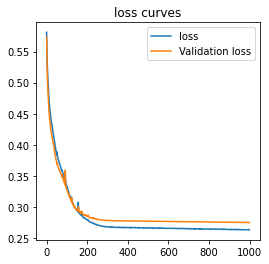

In [8]:
# %% Show loss evolution when training is done
loss = avg_train_losses
val_loss = avg_valid_losses
plt.figure(figsize=(4, 4))
plt.plot(loss[1:], '-', label='loss')
plt.plot(val_loss, '-', label='Validation loss')
plt.legend()

plt.title('loss curves')
plt.savefig('history_checkpoint_batch128_noskip_mask0.0_lossFullimage_patch10.png')